In [15]:

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import temgymbasic.jax_components as comp
from temgymbasic.jax_utils import run_model_for_rays_and_slopes, find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv
from temgymbasic.jax_run import run_model_for_jacobians
from temgymbasic.jax_ray import Ray
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".4"
%matplotlib widget
# jax.config.update("jax_platform_name", "cpu")

ImportError: cannot import name 'run_model_for_rays_and_slopes' from 'temgymbasic.jax_utils' (/home/dl277493/TemGym/src/temgymbasic/jax_utils.py)

In [ ]:
def map_px_on_detector_to_sample(sample_image, detector_image,
                                 sample_pixel_size, det_pixel_size,
                                 ray_sample_coords_x, ray_sample_coords_y,
                                 ray_det_coords_x, ray_det_coords_y,
                                 rotation):

    # Map the pixel intensities from the detector image back onto the sample image.
    # For each detector image from a scan position, we back propagate this image to the input sample coordinates.

    # Args:
    #   sample_image (jnp.array): The selected scan position image on the scan grid (2D array).
    #   detector_image (jnp.array): The selected image measured on the detector (2D array).
    #   sample_pixel_size (float): Pixel size of the sample image.
    #   det_pixel_size (float): Pixel size of the detector image.
    #   ray_sample_coords_x (jnp.array): 1D array of ray x coordinates on the sample (in physical units).
    #   ray_sample_coords_y (jnp.array): 1D array of ray y coordinates on the sample (in physical units).
    #   ray_det_coords_x (jnp.array): 1D array of ray x coordinates on the detector (in physical units).
    #   ray_det_coords_y (jnp.array): 1D array of ray y coordinates on the detector (in physical units).

    # Returns:
    #   jnp.array: The updated sample image with detector intensities added accordingly.

    sample_shape = sample_image.shape
    det_shape = detector_image.shape

    rotation = -rotation
    ray_sample_coords_y_rot = jnp.cos(rotation) * ray_sample_coords_y - jnp.sin(rotation) * ray_sample_coords_x
    ray_sample_coords_x_rot = jnp.sin(rotation) * ray_sample_coords_y + jnp.cos(rotation) * ray_sample_coords_x

    # Convert ray coordinates to pixel indices in the sample image.
    sample_pixel_xs = ray_sample_coords_x_rot / sample_pixel_size + sample_shape[1] / 2
    sample_pixel_ys = ray_sample_coords_y_rot / sample_pixel_size + sample_shape[0] / 2
    sample_pixel_xs = jnp.round(sample_pixel_xs).astype(jnp.int32)
    sample_pixel_ys = jnp.round(sample_pixel_ys).astype(jnp.int32)

    # Convert ray coordinates to pixel indices in the detector image.
    det_pixel_xs = ray_det_coords_x / det_pixel_size + det_shape[1] / 2
    det_pixel_ys = ray_det_coords_y / det_pixel_size + det_shape[0] / 2
    det_pixel_xs = jnp.round(det_pixel_xs).astype(jnp.int32)
    det_pixel_ys = jnp.round(det_pixel_ys).astype(jnp.int32)

    # Gather the detector pixel intensities
    detector_vals = detector_image[(det_pixel_ys, det_pixel_xs)]

    # Continuously add the detector values to the sample image
    sample_image_updated = sample_image.at[(sample_pixel_ys, sample_pixel_xs)].add(detector_vals)

    return sample_image_updated


@jax.jit
def get_shifted_sum(model, fourdstem_det_array, fourdstem_sample_array, semi_conv):
    """
    Compute the shifted sum image by mapping detector contributions back onto the sample.

    Args:
      model (list): Optical model components for propagating rays.
      fourdstem_det_array (jnp.array): Detector images with shape 
          (scan_px_y, scan_px_x, det_px_y, det_px_x).
      fourdstem_sample_array (jnp.array): Sample images with shape 
          (scan_px_y, scan_px_x, sample_px_y, sample_px_x).
      semi_conv (float): The semi-convergence angle of the point source.

    Returns:
      jnp.array: The final accumulated sample image.
    """
    # Unpack model components.
    InputPlane = model[0]
    ScanGrid = model[1]
    Descanner = model[2]
    Detector = model[3]

    # Get scan coordinates (shape: (scan_px_y, scan_px_x, 2)).
    scan_shape = fourdstem_det_array.shape[:2]
    det_shape = fourdstem_det_array.shape[2:]
    scan_coords = ScanGrid.get_coords().reshape(scan_shape[0], scan_shape[1], 2)
    detector_coords_yx = Detector.get_coords()
    descan_error = Descanner.descan_error
    scan_px_size = ScanGrid.pixel_size
    det_px_size = Detector.pixel_size
    rotation = ScanGrid.rotation

    def process_scan(scan_pos, det_image_selected, sample_image_selected):
        """
        Process a single scan position.

        Args:
          scan_pos (jnp.array): The [y, x] coordinates of the scan position.
          det_image_selected (jnp.array): Detector image at this scan.
          sample_image_selected (jnp.array): Sample image patch at this scan.

        Returns:
          jnp.array: Updated sample image after mapping detector contributions.
        """
        scan_y, scan_x = scan_pos[0], scan_pos[1]

        # Prepare input ray positions for this scan point.
        input_ray_positions = jnp.array([[scan_x, scan_y, 0.0, 0.0, 1.0]])
        ray = Ray(
            z=InputPlane.z,
            matrix=input_ray_positions,
            amplitude=jnp.ones(1),
            pathlength=jnp.zeros(1),
            wavelength=jnp.ones(1),
            blocked=jnp.zeros(1, dtype=float)
        )

        # Create a new Descanner with the current scan offsets.
        new_Descanner = comp.Descanner(
            z=ScanGrid.z,
            descan_error=descan_error,
            offset_x=scan_x,
            offset_y=scan_y
        )

        current_model = [InputPlane, ScanGrid, new_Descanner, Detector]

        each_ABCD = run_model_for_jacobians(ray, current_model)

        total_ABCD = each_ABCD[-1] @ each_ABCD[-2] @ each_ABCD[-3]
        sample_to_detector = each_ABCD[2] @ each_ABCD[1]
        detector_to_sample = jnp.linalg.inv(sample_to_detector)

        input_slopes = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
            detector_coords_yx, scan_pos, semi_conv, total_ABCD[0]
        )

        coords = run_model_for_rays_and_slopes(each_ABCD, input_slopes, scan_pos)
        xs, ys, dxs, dys = coords
        detector_rays = jnp.stack([xs[-1], ys[-1], dxs[-1], dys[-1], jnp.ones_like(xs[-1])])
        sample_rays = jnp.dot(detector_to_sample[0], detector_rays)

        sample_rays_x = sample_rays[0]
        sample_rays_y = sample_rays[1]
        det_rays_x = detector_rays[0]
        det_rays_y = detector_rays[1]

        return map_px_on_detector_to_sample(
            sample_image_selected, det_image_selected,
            scan_px_size, det_px_size,
            sample_rays_x, sample_rays_y,
            det_rays_x, det_rays_y,
            rotation
        )
    
    vmap_process_scan = jax.vmap(jax.vmap(process_scan, in_axes=(0)), in_axes=(0))
    sample_images = vmap_process_scan(scan_coords, fourdstem_det_array, fourdstem_sample_array)

    sample_image = jnp.sum(sample_images, axis=(0, 1))

    return sample_image

In [ ]:
def get_transfer_matrices(model, scan_pos_m):

    # Unpack model components.
    InputPlane = model[0]
    ScanGrid = model[1]
    Descanner = model[2]
    Detector = model[3]

    descan_error = Descanner.descan_error
    scan_y, scan_x = scan_pos_m[0], scan_pos_m[1]

    # Prepare input ray positions for this scan point.
    input_ray_positions = jnp.array([[scan_x, scan_y, 0.0, 0.0, 1.0]])

    ray = Ray(
        z=InputPlane.z,
        matrix=input_ray_positions,
        amplitude=jnp.ones(1),
        pathlength=jnp.zeros(1),
        wavelength=jnp.ones(1),
        blocked=jnp.zeros(1, dtype=float)
    )

    # Create a new Descanner with the current scan offsets.
    new_Descanner = comp.Descanner(
        z=ScanGrid.z,
        descan_error=descan_error,
        offset_x=scan_x,
        offset_y=scan_y
    )

    current_model = [InputPlane, ScanGrid, new_Descanner, Detector]

    transfer_matrices = run_model_for_jacobians(ray, current_model)
    total_transfer_matrix = transfer_matrices[-1]
    for tm in reversed(transfer_matrices[:-1]):
        total_transfer_matrix = total_transfer_matrix @ tm
    
    return transfer_matrices

def process_scan(model, transfer_matrices, scan_idx):

    # Unpack model components.
    InputPlane = model[0]
    ScanGrid = model[1]
    Detector = model[3]
    detector_coords_yx = Detector.get_coords()
    scan_pos = ScanGrid.scan_positions[scan_idx]
    semi_conv = InputPlane.semi_conv

    # Prepare the transfer matrices for the system
    total_transfer_matrix = transfer_matrices[-1]
    for tm in reversed(transfer_matrices[:-1]):
        total_transfer_matrix = total_transfer_matrix @ tm
    sample_to_detector = transfer_matrices[-1] @ transfer_matrices[-2] @ transfer_matrices[-3]
    detector_to_sample = np.linalg.inv(sample_to_detector)

    # Find all input slopes for a max semiconvergence angle that will hit the detector pixels
    input_slopes = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
        detector_coords_yx, scan_pos, semi_conv, total_transfer_matrix[0]
    )

    # Run the model for the ray coordinates
    coords = run_model_for_rays_and_slopes(transfer_matrices, input_slopes, scan_pos)

    #Stack them, and perform the matrix multiplication to get the sample coordinates
    xs, ys, dxs, dys = coords
    detector_rays = np.stack([xs[-1], ys[-1], dxs[-1], dys[-1], np.ones_like(xs[-1])])
    sample_rays = np.dot(detector_to_sample[0], detector_rays)

    sample_rays_x = sample_rays[0]
    sample_rays_y = sample_rays[1]
    det_rays_x = detector_rays[0]
    det_rays_y = detector_rays[1]

    return map_px_on_detector_to_sample(
        sample_image_selected, det_image_selected,
        scan_px_size, det_px_size,
        sample_rays_x, sample_rays_y,
        det_rays_x, det_rays_y,
        rotation
    )

In [3]:
data = np.load('fourdstem_overfocused.npy')
from scipy.ndimage import zoom

sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape


sample_image = jnp.array(sample_image, dtype=jnp.complex64)


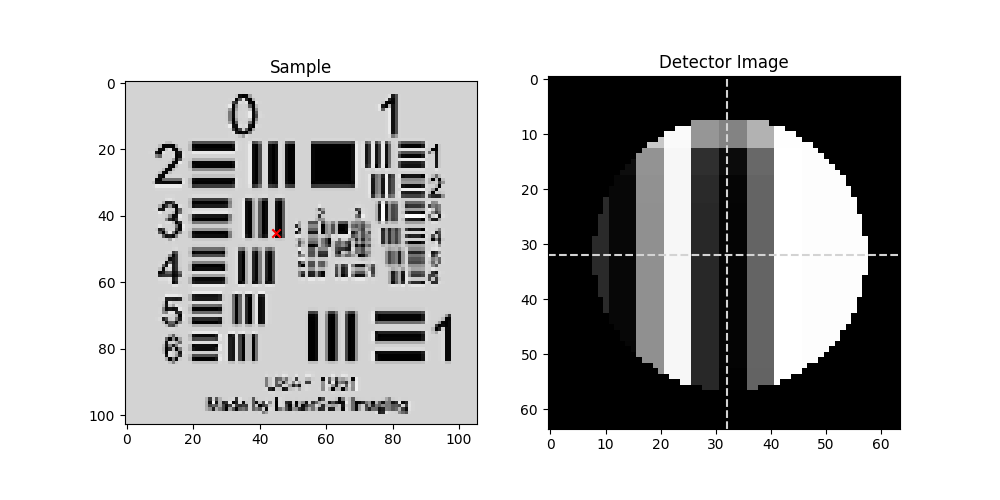

In [4]:
scan_idx_x, scan_idx_y = 45, 45
det_image_selected = data[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(sample_image), 
             cmap='gray')
ax[0].scatter(scan_idx_x, scan_idx_y, c='r', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(det_image_selected.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(det_image_selected.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

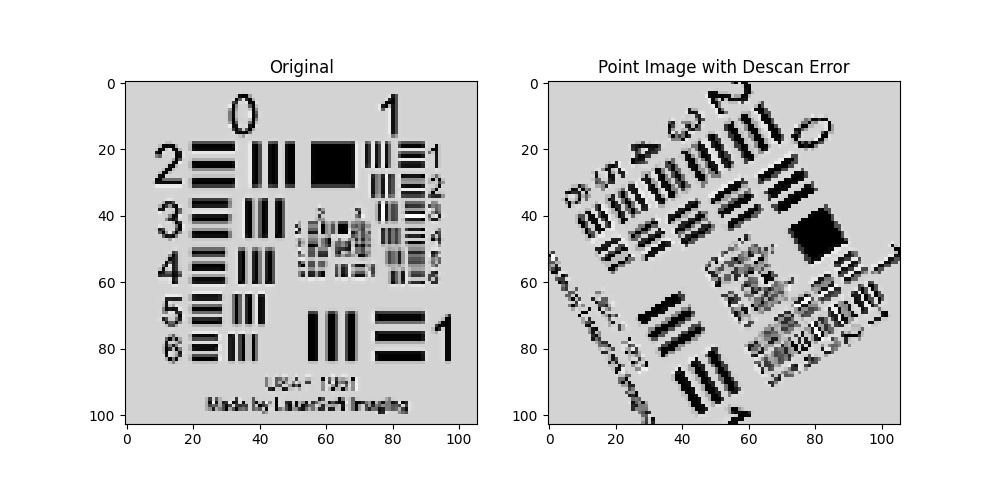

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title('Original')
axes[0].imshow(np.abs(sample_image), cmap='gray')
axes[1].set_title('Point Image with Descan Error')
axes[1].imshow(np.abs(data[:, :, det_image_selected.shape[0]//2, det_image_selected.shape[1]//2]), cmap='gray')

In [6]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 
# Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
# Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix
Axx, Ayy, Cxx, Cyy = 0, 0, 0, 0
Axy, Ayx, Cxy, Cyx = 0, 0, 0, 0

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]
# descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

#Set up the parameters for the simulation
defocus = 0.01
semi_conv = 0.05
camera_length = 1.0
scan_size = sample_image_shape
det_size = (64, 64)
scan_px_size = 0.0001
det_px_size= 0.002
rotation = 45

params_dict = {
    'defocus': defocus,
    'semi_conv': semi_conv,
    'camera_length': camera_length,
    'scan_size': scan_size,
    'det_size': det_size,
    'scan_px_size': scan_px_size,
    'det_px_size': det_px_size,
    'rotation': rotation,
    'descan_error': descan_error
}

#Create ray input z plane
crossover_z = jnp.zeros((1))

fourdstem_sample_array = jnp.zeros((scan_size[0], scan_size[1], scan_size[0], scan_size[1]), dtype=jnp.complex64)

In [7]:
InputPlane = comp.InputPlane(z=crossover_z)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), pixel_size=params_dict['scan_px_size'], shape=params_dict['scan_size'], rotation=params_dict['rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=det_size, pixel_size=params_dict['det_px_size'])
model = [InputPlane, ScanGrid, Descanner, Detector]

input_ray_positions = jnp.array([[0.0, 0.0, 0.0, 0.0, 1.0]])

ray = Ray(
    z=jnp.array([0.0]),
    matrix=input_ray_positions,
    amplitude=jnp.ones(1),
    pathlength=jnp.zeros(1),
    wavelength=jnp.ones(1),
    blocked=jnp.zeros(1, dtype=float)
)

In [8]:
num_scan_positions = scan_size[0] * scan_size[1]
each_ABCD = run_model_for_jacobians(ray, model)
total_ABCD = each_ABCD[-1] @ each_ABCD[-2] @ each_ABCD[-3] @ each_ABCD[-4]
detector_coords_yx = Detector.get_coords()
scan_pos = jnp.array([scan_idx_y, scan_idx_x])
input_slopes = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
    detector_coords_yx, scan_pos, semi_conv, total_ABCD[0]
)
coords = run_model_for_rays_and_slopes(each_ABCD, input_slopes, scan_pos)

xs, ys, dxs, dys = coords

detector_rays = jnp.stack([xs[-1], ys[-1], dxs[-1], dys[-1], jnp.ones_like(xs[-1])])
sample_rays = jnp.dot(total_ABCD[0], detector_rays)
sample_rays_x = sample_rays[0]
sample_rays_y = sample_rays[1]
det_rays_x = detector_rays[0]
det_rays_y = detector_rays[1]
sample_image_selected = fourdstem_sample_array[scan_idx_y, scan_idx_x]


shifted_sum_image = get_shifted_sum(model, data, fourdstem_sample_array, semi_conv)

In [9]:
# run_model_for_jacobians_stats = %timeit -o run_model_for_jacobians(ray, model).block_until_ready()
# find_input_slopes_stats = %timeit -o find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(detector_coords_yx, scan_pos, semi_conv, total_ABCD[0]).block_until_ready()
# run_model_for_rays_and_slopes_stats = %timeit -o run_model_for_rays_and_slopes(each_ABCD, input_slopes, scan_pos).block_until_ready()
# map_px_on_detector_to_sample_stats = %timeit -o map_px_on_detector_to_sample(sample_image_selected, det_image_selected, scan_px_size, det_px_size,sample_rays_x, sample_rays_y,det_rays_x, det_rays_y).block_until_ready()


In [10]:
# print(f"Run Model For Jacobians Total Time for all scan positions: {run_model_for_jacobians_stats.best * num_scan_positions:.4f} seconds")
# print(f"Find Input Slopes Total Time for all scan positions: {find_input_slopes_stats.best * num_scan_positions:.4f} seconds")
# print(f"Run Model For Rays and Slopes Total Time for all scan positions: {run_model_for_rays_and_slopes_stats.best * num_scan_positions:.4f} seconds")
# print(f"Map Px on Det Time for all scan positions: {map_px_on_detector_to_sample_stats.best * num_scan_positions:.4f} seconds")


In [11]:
# %timeit get_shifted_sum(model, data, fourdstem_sample_array, semi_conv).block_until_ready()

Text(0.5, 1.0, 'Shifted Sum Image')

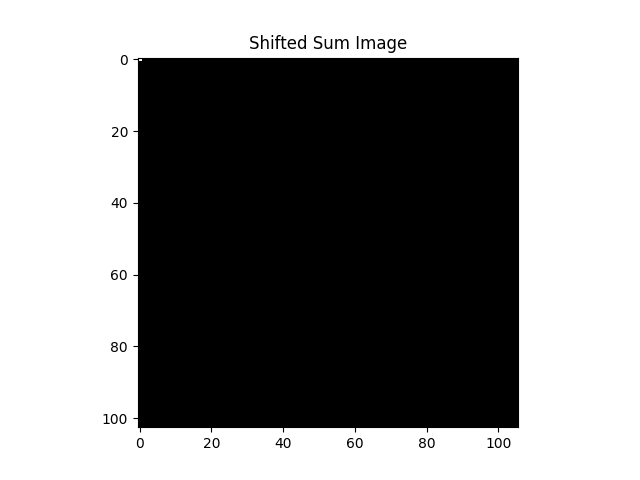

In [12]:
plt.figure()
plt.imshow(np.abs(shifted_sum_image), cmap='gray')
plt.title('Shifted Sum Image')

In [13]:
import panel as pn
pn.extension()

In [14]:
from libertem_ui.live_plot import ApertureFigure
from bokeh.models.formatters import PrintfTickFormatter

shifted_sum_array = np.random.uniform(size=det_size)

def run_model_inner(params_dict):
    defocus = params_dict['defocus']
    semi_conv = params_dict['semi_conv']
    camera_length = params_dict['camera_length']
    scan_size = params_dict['scan_size']
    det_size = params_dict['det_size']
    scan_px_size = params_dict['scan_px_size']
    det_px_size = params_dict['det_px_size']
    rotation = params_dict['rotation']
    descan_error = params_dict['descan_error']

    
    InputPlane = comp.InputPlane(z=crossover_z)
    ScanGrid = comp.ScanGrid(z=jnp.array([defocus]), pixel_size=scan_px_size, shape=sample_image_shape)
    Rotator = comp.Rotator(z=jnp.array([defocus]), angle=rotation)
    Descanner = comp.Descanner(z=jnp.array([defocus]), descan_error=descan_error, offset_x=0.0, offset_y=0.0)
    Detector = comp.Detector(z=jnp.array([camera_length]), shape=det_size, pixel_size=det_px_size)
    model = [InputPlane, ScanGrid, Descanner, Detector]


    shifted_sum_image = get_shifted_sum(model, data, fourdstem_sample_array, semi_conv)

    return np.abs(shifted_sum_image)


defocus_slider = pn.widgets.FloatSlider(name="defocus", value=0.001, start=0.001, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f m'))
semi_conv_slider = pn.widgets.FloatSlider(name="semi_conv", value=0.01, start=0.01, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f slope'))
camera_length_slider = pn.widgets.FloatSlider(name="camera_length", value=1.0, start=0.1, end=10, format=PrintfTickFormatter(format='%.3f m'))
scan_px_size_slider = pn.widgets.FloatSlider(name="scan_px_size", value=0.0001, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
det_px_size_slider = pn.widgets.FloatSlider(name="det_px_size", value=.002, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
rotation_slider = pn.widgets.FloatSlider(name="rotation", start=0., end=360, step=0.01, value=0.02, format=PrintfTickFormatter(format='%.3f degrees'))

Axx_slider = pn.widgets.FloatSlider(name="Axx", value=4, start=-10, end=10, step=0.1)
Axy_slider = pn.widgets.FloatSlider(name="Axy", value=6, start=-10, end=10, step=0.1)
Ayx_slider = pn.widgets.FloatSlider(name="Ayx", value=-7, start=-10, end=10, step=0.1)
Ayy_slider = pn.widgets.FloatSlider(name="Ayy", value=3, start=-10, end=10, step=0.1)
Cxx_slider = pn.widgets.FloatSlider(name="Cxx", value=-5, start=-10, end=10, step=0.1)
Cxy_slider = pn.widgets.FloatSlider(name="Cxy", value=-3, start=-10, end=10, step=0.1)
Cyx_slider = pn.widgets.FloatSlider(name="Cyx", value=5, start=-10, end=10, step=0.1)
Cyy_slider = pn.widgets.FloatSlider(name="Cyy", value=-4, start=-10, end=10, step=0.1)

figure = (
    ApertureFigure
    .new(shifted_sum_array, tools=False, maxdim=600)
)


def run_model(*e):
    defocus_v = defocus_slider.value
    semi_conv_v = semi_conv_slider.value
    camera_length_v = camera_length_slider.value
    scan_px_size_v = scan_px_size_slider.value
    det_px_size_v = det_px_size_slider.value
    rotation_v = rotation_slider.value

    descan_error_v = [Axx_slider.value, Axy_slider.value, Ayx_slider.value, Ayy_slider.value, 
                      Cxx_slider.value, Cxy_slider.value, Cyx_slider.value, Cyy_slider.value]

    params_dict = {
        'defocus': defocus_v,
        'semi_conv': semi_conv_v,
        'camera_length': camera_length_v,
        'scan_size': sample_image_shape,
        'det_size': det_size,
        'scan_px_size': scan_px_size_v,
        'det_px_size': det_px_size_v,
        'rotation': rotation_v,
        'descan_error': descan_error_v}

    image = run_model_inner(params_dict)
    figure.im.update(image)


defocus_slider.param.watch(run_model, 'value_throttled')
semi_conv_slider.param.watch(run_model, 'value_throttled')
camera_length_slider.param.watch(run_model, 'value_throttled')
scan_px_size_slider.param.watch(run_model, 'value_throttled')
det_px_size_slider.param.watch(run_model, 'value_throttled')
rotation_slider.param.watch(run_model, 'value_throttled')
Axx_slider.param.watch(run_model, 'value_throttled')
Axy_slider.param.watch(run_model, 'value_throttled')
Ayx_slider.param.watch(run_model, 'value_throttled')
Ayy_slider.param.watch(run_model, 'value_throttled')
Cxx_slider.param.watch(run_model, 'value_throttled')
Cxy_slider.param.watch(run_model, 'value_throttled')
Cyx_slider.param.watch(run_model, 'value_throttled')
Cyy_slider.param.watch(run_model, 'value_throttled')

pn.Row(
    pn.Column(
        defocus_slider,
        semi_conv_slider,
        camera_length_slider,
        scan_px_size_slider,
        det_px_size_slider,
        rotation_slider,
        pn.Row(
            pn.Column(
                Axx_slider,
                Axy_slider,
                Ayx_slider,
                Ayy_slider
            ),
            pn.Column(
                Cxx_slider,
                Cxy_slider,
                Cyx_slider,
                Cyy_slider
            )
        )
    ),
    figure.layout
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7d9f542d-469b-4e48-8674-df9542ca32bd': {'version…